# Training of -layer NN with basic features
In this notebook, a vanilla 2-layer neural network is trained on all basic-engineered features.

- ReLU after the first liner layer
- Sigmoid after the second linear layer
- Batch Size: 64
- Hidden dim: 16
- Learning Rate: 0.1
- Num. of epochs: 100

We will save the models in "models/vanillann" of our Google Drive.


## 0. Imports and Constants
- Change the path in "cw_dir" to your local Google Drive sync location

In [1]:
############## AUTORELOAD MAGIC ###################
%load_ext autoreload
%autoreload 2
###################################################

############## FUNDAMENTAL MODULES ################
import json
from PIL import Image
import os
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
 ##################################################

############## TASK-SPECIFIC MODULES ##############
sys.path.append(os.path.join(os.getcwd(),"src"))
from vanilla_dataset import VanillaDataset, DataLoader
from vanilla_nn import VanillaNN
from evaluate import evaluate_model
from train import training_loop, plot_losses
from dataloader import custom_dataloader
###################################################


####################### CONSTANTS ########################
users = ["patriziopalmisano", "onurdenizguler", "jockl"]
SPLITS = ["train", "dev", "test"]
TRAIN, DEV, TEST, TXT, IMG = "train", "dev", "test", "txt", "img"
FE_METHODS = ["txt_embeddings", "img_embeddings", "concat", "sum", "mean", "hadamard"]
#FE_METHODS += ["concat_cos", "sum_cos", "mean_cos", "hadamard_cos"]
##########################################################

############## DATA SCIENCE & ML MODULES #################
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch
import pandas as pd
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import classification_report
##########################################################

####################### SELECT ###########################
user = users[0] # SELECT USER
version = "v2" # SELECT DATASET VERSION
dataset_version = version
##########################################################

if user in users[:2]:
    data_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_{version}"
    cw_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/"

else:
    data_dir = f"/home/jockl/Insync/check.worthiness@gmail.com/Google Drive/data/CT23_1A_checkworthy_multimodal_english_{dataset_version}"
    cw_dir = "/home/jockl/Insync/check.worthiness@gmail.com/Google Drive"

features_dir = f"{data_dir}/features"
labels_dir = f"{data_dir}/labels"
models_dir = f"{cw_dir}/models/vanillannWithVal"

# 1. Dictionary Keys
In this notebook, we will use dictionaries to reference corresponding data splits, feature engineering methods, labels, dataloaders etc. The following keys are used all the way:

In [2]:
# CONSTANT DICT KEYS -> MOVED TO IMPORTS!!!!
# SPLITS = ["train", "dev", "test"]
# FE_METHODS = ["concat", "concat_cos", "sum", "sum_cos", "mean", "mean_cos", "hadamard", "hadamard_cos"]

Note that the test split is not used in this notebook!

## 2. Load Training, Dev and Test Labels
First, we load the labels from the pickle files. We will later use them to set up our Dataloaders.

In [3]:
# Load training and dev labels from pickle file as np.array
split_to_labels = {split: np.load(f"{labels_dir}/{split}_labels_{dataset_version}.pickle", allow_pickle=True) for split in SPLITS}

Our label arrays have the following dimensions:

In [4]:
for split in SPLITS:
    print(f"{split} labels: {split_to_labels[split].shape} {split_to_labels[split][:10]}")

train labels: (2356,) [1 1 0 1 0 0 0 0 0 0]
dev labels: (271,) [0 0 0 1 1 0 0 0 1 1]
test labels: (548,) [0 1 0 0 1 0 0 0 0 0]


## 3. Load Engineered Features
Now, all engineered feature matrices for the train and dev split are loaded from their respective pickle files. We store them in a dictionary that maps split to feature method feature matrix.


In [5]:
# Load all engineered feature matrices for train and dev split
split_to_method_to_matrix = {split: {fe_method: np.load(f"{features_dir}/{fe_method}/{fe_method}_{split}_{dataset_version}.pickle", allow_pickle=True) for fe_method in FE_METHODS} for split in SPLITS}

Those are the shapes of our feature matrices:

In [6]:
for split in SPLITS:
    for fe_method in FE_METHODS:
        print(f"{split}, {fe_method}: {split_to_method_to_matrix[split][fe_method].shape}")

train, txt_embeddings: (2356, 768)
train, img_embeddings: (2356, 768)
train, concat: (2356, 1536)
train, sum: (2356, 768)
train, mean: (2356, 768)
train, hadamard: (2356, 768)
dev, txt_embeddings: (271, 768)
dev, img_embeddings: (271, 768)
dev, concat: (271, 1536)
dev, sum: (271, 768)
dev, mean: (271, 768)
dev, hadamard: (271, 768)
test, txt_embeddings: (548, 768)
test, img_embeddings: (548, 768)
test, concat: (548, 1536)
test, sum: (548, 768)
test, mean: (548, 768)
test, hadamard: (548, 768)


# 3. Set up the PyTorch Datasets and Dataloaders
We set up a PyTorch Dataset and a Dataloader for every split and feature matrix loaded in the previous section. First, we define a batch size that every Dataloader uses. This batch size is constant throughout this notebook.

In [7]:
# Define hyperparameters
# Define batch size for all Dataloaders
batch_size = 16

Now, we instantiate our Datasets and Dataloaders.

In [8]:
# Instantiate VanillaDatasets
split_to_method_to_dataset = {split: {fe_method: VanillaDataset(split_to_method_to_matrix[split][fe_method], split_to_labels[split]) for fe_method in FE_METHODS} for split in SPLITS}

# Instantiate Dataloaders
split_to_method_to_dataloader = {split: {fe_method: DataLoader(split_to_method_to_dataset[split][fe_method], batch_size=batch_size) for fe_method in FE_METHODS} for split in SPLITS}

Let's have a look at the first batch from the dataloader of the train split, using the plainly concatenated features:

In [9]:
# Get example dataset/dataloader from the dictionaries
example_train_loader = split_to_method_to_dataloader["train"]["txt_embeddings"]
example_train_set = split_to_method_to_dataset["train"]["txt_embeddings"]

# Print info
print(f"No. of examples in the training set: {len(example_train_set[0][0])}")
for batch_no, batch in enumerate(example_train_loader):
    print(f"Batch No: {batch_no}\nfeatures in batch: {batch[0].shape}\nlabels in batch: {batch[1].shape}")
    break

No. of examples in the training set: 768
Batch No: 0
features in batch: torch.Size([16, 768])
labels in batch: torch.Size([16])


In [10]:
# Get a balanced training dataloader for txt_embeddings
example_train_loader_balanced = custom_dataloader(split_to_method_to_dataset['train']['txt_embeddings'], 'train', batch_size=16)
for batch_no, batch in enumerate(example_train_loader_balanced):
    print(f"Batch No: {batch_no}\nfeatures in batch: {batch[0].shape}\nlabels in batch: {batch[1].shape}")
    break

Batch No: 0
features in batch: torch.Size([16, 768])
labels in batch: torch.Size([16])


# 4. Plot classes distribution
We plot the class distribution for each batch, both for unbalanced and balanced batches

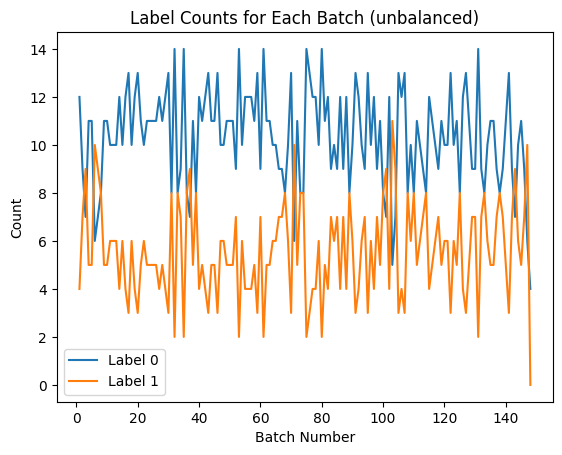

In [11]:
batch_count = 0
label_counts = []

# Iterate over the batches in train_dl
for batch in example_train_loader:
    features, labels = batch

    # Count the labels in the current batch
    count_0 = (labels == 0).sum().item()
    count_1 = (labels == 1).sum().item()

    # Store the label counts for the current batch
    label_counts.append((count_0, count_1))

    # Increment the batch count
    batch_count += 1

# Prepare the x-axis labels
batch_numbers = list(range(1, len(label_counts) + 1))

# Extract the counts for label '0' and label '1' into separate lists
counts_0 = [count_0 for count_0, _ in label_counts]
counts_1 = [count_1 for _, count_1 in label_counts]

# Plot the label counts
plt.plot(batch_numbers, counts_0, label='Label 0')
plt.plot(batch_numbers, counts_1, label='Label 1')
plt.xlabel('Batch Number')
plt.ylabel('Count')
plt.title('Label Counts for Each Batch (unbalanced)')
plt.legend()
plt.show()


In [12]:
sum(counts_1)

820

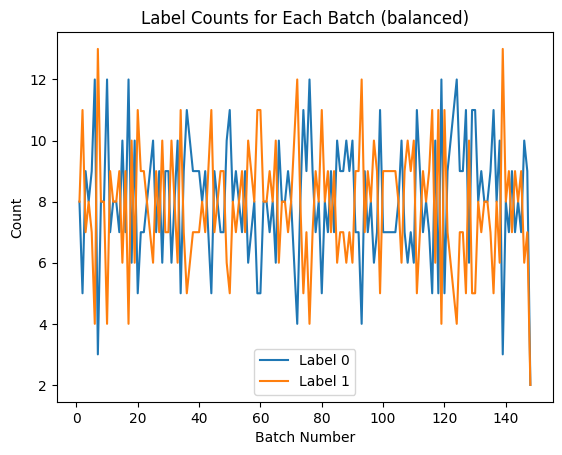

In [13]:
batch_count = 0
label_counts = []

# Iterate over the batches in train_dl
for batch in example_train_loader_balanced:
    features, labels = batch

    # Count the labels in the current batch
    count_0 = (labels == 0).sum().item()
    count_1 = (labels == 1).sum().item()

    # Store the label counts for the current batch
    label_counts.append((count_0, count_1))

    # Increment the batch count
    batch_count += 1

# Prepare the x-axis labels
batch_numbers = list(range(1, len(label_counts) + 1))

# Extract the counts for label '0' and label '1' into separate lists
counts_0 = [count_0 for count_0, _ in label_counts]
counts_1 = [count_1 for _, count_1 in label_counts]

# Plot the label counts
plt.plot(batch_numbers, counts_0, label='Label 0')
plt.plot(batch_numbers, counts_1, label='Label 1')
plt.xlabel('Batch Number')
plt.ylabel('Count')
plt.title('Label Counts for Each Batch (balanced)')
plt.legend()
plt.show()


# 5. Train and Save Models
In this section, we train a network for all feature engineering methods. The following parameters are used:

## 5.1 Train a model with unbalanced batches

In [14]:
device = torch.device('cpu')

In [15]:
# Train a model on the "text_embedding" features
# Get dataset and dataloader
fe_method = "txt_embeddings"
train_set = split_to_method_to_dataset["train"][fe_method]
train_dataloader = split_to_method_to_dataloader["train"][fe_method]
dev_set = split_to_method_to_dataset["dev"][fe_method]
dev_dataloader = split_to_method_to_dataloader["dev"][fe_method]
test_set = split_to_method_to_dataset["test"][fe_method]
test_dataloader = split_to_method_to_dataloader["test"][fe_method]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:15<00:00, 15.94it/s]


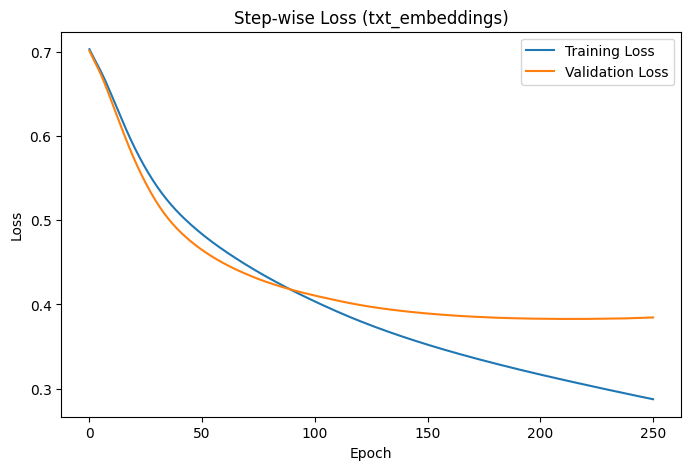

In [16]:
# Model Hyperparameters
input_dim = len(train_set[0][0])
output_dim = 1
layer_sizes = [input_dim, 64, 32, output_dim]
model = VanillaNN(layer_sizes)
model.to(device)
# Training Hyperparameters
loss_fn = torch.nn.BCELoss()
lr = 5e-6
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 250

#Train the model
train_losses, val_losses = training_loop(device, train_dataloader, dev_dataloader, optimizer, model, loss_fn, num_epochs)

# Plot losses
plot_losses(num_epochs, train_losses, val_losses, fe_method)

In [17]:
# Compute basic metrics
print(f"\n{fe_method}\n")
model.to("cpu")
print(evaluate_model(model, test_dataloader))


txt_embeddings

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88       374
         1.0       0.74      0.72      0.73       174

    accuracy                           0.83       548
   macro avg       0.80      0.80      0.80       548
weighted avg       0.83      0.83      0.83       548



## 5.1 Train a model with balanced batches


In [18]:
# Train a model on the "text_embedding" features
# Get dataset and dataloader
fe_method = "txt_embeddings"
train_set = split_to_method_to_dataset["train"][fe_method]
train_dataloader = custom_dataloader(split_to_method_to_dataset['train'][fe_method], 'train', batch_size=batch_size)
dev_set = split_to_method_to_dataset["dev"][fe_method]
dev_dataloader = split_to_method_to_dataloader["dev"][fe_method]
test_set = split_to_method_to_dataset["test"][fe_method]
test_dataloader = split_to_method_to_dataloader["test"][fe_method]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.80it/s]


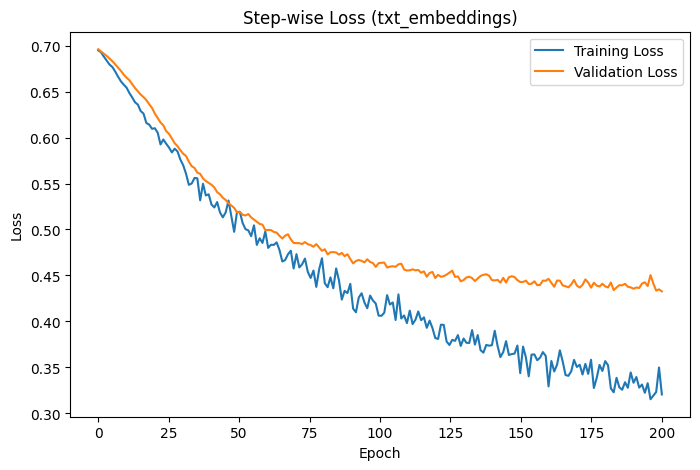

In [19]:
# Model Hyperparameters
input_dim = len(train_set[0][0])
output_dim = 1
layer_sizes = [input_dim, 64, 32, output_dim]
model_bal = VanillaNN(layer_sizes)
model_bal.to(device)
# Training Hyperparameters
loss_fn = torch.nn.BCELoss()
lr = 5e-6
optimizer = torch.optim.Adam(model_bal.parameters(), lr=lr)
num_epochs = 200

#Train the model
train_losses, val_losses = training_loop(device, train_dataloader, dev_dataloader, optimizer, model_bal, loss_fn, num_epochs)

# Plot losses
plot_losses(num_epochs, train_losses, val_losses, fe_method)

model_path = f"{models_dir}/{fe_method}_{dataset_version}_balanced.pt"
torch.save(model_bal.state_dict(), model_path)


In [20]:
# Compute basic metrics
print(f"\n{fe_method}\n")
model_bal.to("cpu")
print(evaluate_model(model_bal, test_dataloader))


txt_embeddings

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85       374
         1.0       0.66      0.79      0.72       174

    accuracy                           0.80       548
   macro avg       0.78      0.80      0.78       548
weighted avg       0.82      0.80      0.81       548

